In [1]:
# %cd /content/drive/MyDrive/ML_internship_projects/ConnectTel-churn-prediction

# !pip install -r requirements.txt


In [2]:

import os

project_root = "/content/drive/MyDrive/ML_internship_projects/ConnectTel-churn-prediction"
os.chdir(project_root)
print("Working Directory:", os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


Working Directory: /content/drive/MyDrive/ML_internship_projects/ConnectTel-churn-prediction


In [3]:
os.makedirs("assets", exist_ok=True)
os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)

In [4]:
excel_path = "/content/drive/MyDrive/ML_internship_projects/ConnectTel-churn-prediction/data /raw /Telco_customer_churn.xlsx"
csv_path = "/content/drive/MyDrive/ML_internship_projects/ConnectTel-churn-prediction/data /raw /Telco_customer_churn1.csv"

In [5]:
df_excel = pd.read_excel(excel_path)
df_excel.to_csv(csv_path, index=False)

In [6]:
df_raw = pd.read_csv(csv_path)
df = df_raw.copy()

## Dataset Overview

The raw dataset was loaded from Kaggle and preserved without modification.
All subsequent cleaning and feature engineering steps are performed on a copied dataframe.


In [7]:
print(df.head())
print(df.shape)
print(df.info())


   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payment Method  Monthly Charges Tota

In [8]:
df.columns = df.columns.str.strip().str.replace(" ", "_")

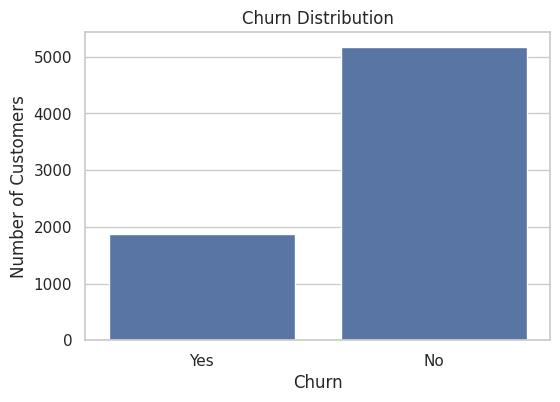

In [22]:
#EDA
# 1. Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="Churn_Label", data=df)
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Number of Customers")
plt.savefig("/content/drive/MyDrive/ML_internship_projects/ConnectTel-churn-prediction/assets/churn_distribution.png", bbox_inches="tight")
plt.show()

**Insight:**  
The dataset is moderately imbalanced, with a significantly larger proportion of non-churned customers compared to churned customers. This indicates that accuracy alone may be misleading, and metrics such as recall and ROC-AUC will be more appropriate for model evaluation.


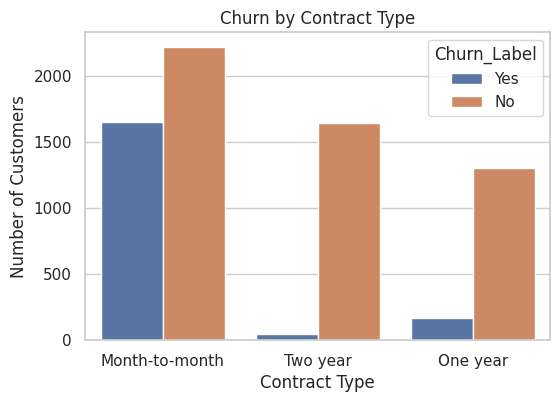

In [23]:
# 2. Churn by Contract Type
plt.figure(figsize=(6, 4))
sns.countplot(x="Contract", hue="Churn_Label", data=df)
plt.title("Churn by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Number of Customers")
plt.savefig("assets/churn_by_contract.png", bbox_inches="tight")
plt.show()

**Insight:**  
Customers on month-to-month contracts exhibit substantially higher churn compared to those on one-year or two-year contracts. This suggests that lack of long-term commitment is a major driver of customer attrition.


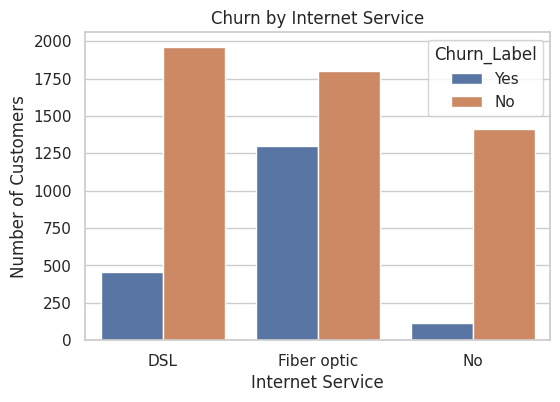

In [24]:
# 3. Churn by Internet Service
plt.figure(figsize=(6, 4))
sns.countplot(x="Internet_Service", hue="Churn_Label", data=df)
plt.title("Churn by Internet Service")
plt.xlabel("Internet Service")
plt.ylabel("Number of Customers")
plt.savefig("assets/churn_by_internet_service.png", bbox_inches="tight")
plt.show()


**Insight:**  
Customers using fiber optic internet services show higher churn rates compared to DSL users. This may indicate dissatisfaction related to pricing or service quality among fiber optic customers.


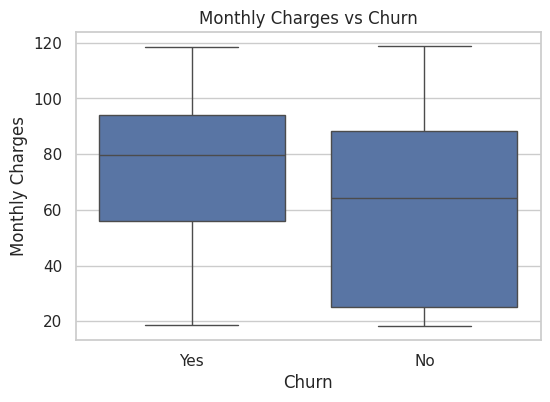

In [25]:
# 4. Monthly Charges vs Churn
plt.figure(figsize=(6, 4))
sns.boxplot(x="Churn_Label", y="Monthly_Charges", data=df)
plt.title("Monthly Charges vs Churn")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.savefig("assets/monthly_charges_vs_churn.png", bbox_inches="tight")
plt.show()

**Insight:**  
Churned customers generally have higher monthly charges compared to non-churned customers. This suggests that pricing sensitivity plays an important role in churn behavior.


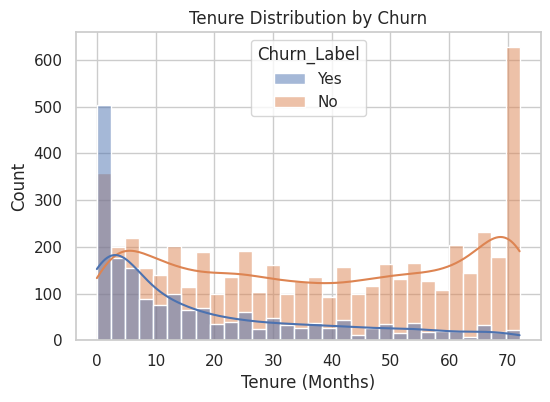

In [26]:
plt.figure(figsize=(6,4))

sns.histplot(
    data=df,
    x="Tenure_Months",
    hue="Churn_Label",
    bins=30,
    kde=True
)

plt.title("Tenure Distribution by Churn")
plt.xlabel("Tenure (Months)")
plt.ylabel("Count")

plt.savefig("assets/tenure_distribution_by_churn.png", bbox_inches="tight")
plt.show()


**Insight:**  
Customers with shorter tenure are significantly more likely to churn, while customers with longer tenure tend to remain loyal. The churn rate is highest in the initial months of service and steadily decreases as tenure increases, highlighting the importance of early-stage customer engagement and onboarding strategies.


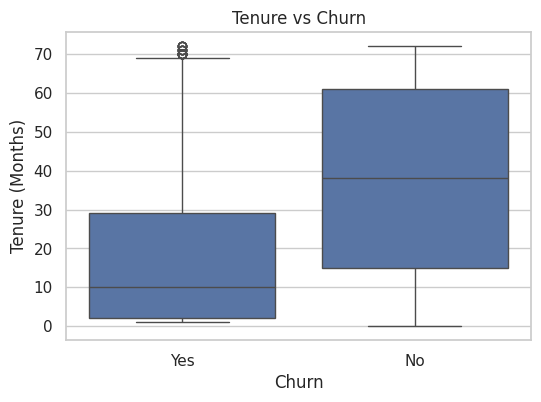

In [27]:
# 5.PLOT: Tenure vs Churn
plt.figure(figsize=(6, 4))
sns.boxplot(x="Churn_Label", y="Tenure_Months", data=df)
plt.title("Tenure vs Churn")
plt.xlabel("Churn")
plt.ylabel("Tenure (Months)")
plt.savefig("assets/tenure_vs_churn.png", bbox_inches="tight")
plt.show()


**Insight:**  
Customers with shorter tenure are significantly more likely to churn, while customers with longer tenure tend to remain loyal. This highlights the importance of early engagement and onboarding strategies.


## Hypothesis Evaluation

- Customers with fiber optic internet churn more than DSL users.
- Month-to-month contracts significantly increase churn risk.
- Customers with shorter tenure are more likely to churn.
- Higher monthly charges are associated with higher churn probability.


In [15]:
#DATA Cleaning
drop_cols = [
    "Count",
    "Country",
    "State", "City",
    "Zip_Code",
    "Lat_Long",
    "Latitude",
    "Longitude",
    "Churn_Value",
    "Churn_Score",
    "Churn_Reason"
]

df.drop(columns=drop_cols, inplace=True)

In [16]:
# Convert Total Charges
df["Total_Charges"] = pd.to_numeric(
    df["Total_Charges"],
    errors="coerce"
)

df["Total_Charges"] = df["Total_Charges"].fillna(
    df["Total_Charges"].median()
)


In [17]:
#feature engineering

# Charges normalized by tenure
df["TotalChargesPerTenure"] = df["Total_Charges"] / (df["Tenure_Months"] + 1)

In [18]:
# Count of subscribed services
service_cols = [
    "Online_Security", "Online_Backup", "Device_Protection",
    "Tech_Support", "Streaming_TV", "Streaming_Movies"
]

df["ServiceCount"] = (df[service_cols] == "Yes").sum(axis=1)

In [19]:
# Long-term contract flag
df["IsLongTermContract"] = df["Contract"].apply(
    lambda x: 0 if x == "Month-to-month" else 1
)

In [20]:
# Final Inspection
print(df.info())
print(df.head())
print(df["Churn_Label"].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             7043 non-null   object 
 1   Gender                 7043 non-null   object 
 2   Senior_Citizen         7043 non-null   object 
 3   Partner                7043 non-null   object 
 4   Dependents             7043 non-null   object 
 5   Tenure_Months          7043 non-null   int64  
 6   Phone_Service          7043 non-null   object 
 7   Multiple_Lines         7043 non-null   object 
 8   Internet_Service       7043 non-null   object 
 9   Online_Security        7043 non-null   object 
 10  Online_Backup          7043 non-null   object 
 11  Device_Protection      7043 non-null   object 
 12  Tech_Support           7043 non-null   object 
 13  Streaming_TV           7043 non-null   object 
 14  Streaming_Movies       7043 non-null   object 
 15  Cont

## Phase 1 Summary

- Raw data was preserved and not modified.
- Exploratory Data Analysis was performed to understand churn drivers.
- Leakage and post-churn variables were removed.
- New behavioral features were engineered.
- The cleaned dataset is saved for modeling in Phase 2.


In [21]:
# Save Cleaned Dataset
df.to_csv(
    "data/processed/churn_cleaned.csv",
    index=False
)

print("Cleaned dataset saved successfully.")

Cleaned dataset saved successfully.
